In [1]:
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv("../data/all_data_no_tweet_text.csv", sep = "\t")
data = data[data['Dataset'].isin(['mtsd', 'constance', 'semevala', 'semevalb', 'presidents'])]
datasets_map = {'mtsd' : 'mtsd', 'constance' : 'cons', 'semevala' : 'sea', 'semevalb' : 'seb', 'presidents' : 'pres'}
methods_map = {'Majority (Target)' : 'majority-target',
               'Majority (Dataset)': 'majority-dataset',
               'SVM-SD' : 'SVM-SD (ST)',
               'SentiTreeBank': 'STB (UTS)',
               'Sentistrength': 'STS (UTS)',
               'MPQA' : 'MPQA (UTS)',
               'Random': 'random',
               'In-domain (BERT)' : 'BERT (custom)',
               'VADER' : 'VADER (UTS)',
               'LabMT' : 'LabMT (UTS)',
               'TD-LSTM' : 'TD-LSTM (TS)',
               'In-domain (SVM)' : 'SVM (custom)',
               'In-domain (MNB)' : 'MNB (custom)',
               'DSSD' : 'DSSD (ST)',
               'In-domain (LR)' : 'LR (custom)'}

data['Dataset'] = data['Dataset'].map(datasets_map)
data.head()

,ID,Target,Stance,Dataset
0,0,Hillary Clinton,AGAINST,sea
1,1,Hillary Clinton,AGAINST,sea
2,2,Hillary Clinton,AGAINST,sea
3,3,Hillary Clinton,AGAINST,sea
4,4,Hillary Clinton,AGAINST,sea


In [3]:
data['Target'].unique()

array(['Hillary Clinton', 'Donald Trump', 'Vladimir Putin', 'Joko Widodo',
       'Emmanuel Macron', 'Jacob Zuma', 'Recep Tayyip Erdoğan'],
      dtype=object)

In [4]:
data.head()

,ID,Target,Stance,Dataset
0,0,Hillary Clinton,AGAINST,sea
1,1,Hillary Clinton,AGAINST,sea
2,2,Hillary Clinton,AGAINST,sea
3,3,Hillary Clinton,AGAINST,sea
4,4,Hillary Clinton,AGAINST,sea


In [5]:
data.columns

Index(['ID', 'Target', 'Stance', 'Dataset'], dtype='object')

In [6]:
# need tweets to run this
# df = data.groupby(['Target', 'Dataset',  'Direct_Stance', 'Stance']).size().unstack().unstack()
# df['Total'] = df.sum(axis = 1)
# df


In [7]:
# print(df.to_latex())

### Baselines: majority and random

In [8]:
# find majority group in each dataset
import operator
import random

def baselines(data):
    dataset_majority = {}
    data_by_dataset = data.groupby('Dataset')
    for i in data.Dataset.unique():
        datax = data_by_dataset.get_group(i)
        datasize = datax.groupby('Stance').size()
#     print(i)
#     print(datasize)
        dataset_majority[i] = max(datasize.iteritems(), key = operator.itemgetter(1))[0]
    
    
    target_majority = {}
    data_by_target = data.groupby('Target')
    for i in data.Target.unique():
        datax = data_by_target.get_group(i)
        datasize = datax.groupby('Stance').size()
#     print(i)
#     print(datasize)
        target_majority[i] = max(datasize.iteritems(), key = operator.itemgetter(1))[0]    
    
    data['Majority (Dataset)']    = [dataset_majority[row['Dataset']] for n, row in data.iterrows()]
    data['Majority (Target)']    = [target_majority[row['Target']] for n, row in data.iterrows()]
    data['Random'] = [random.choice(['AGAINST', 'FAVOR', 'NONE']) for i in range(len(data))]
    
    return data

### Get results

In [9]:
from util import get_results

In [10]:
import os

In [12]:
in_domain_results = {}
from functools import reduce


mega_all_results = []
mega_all_dataset_results = []
runs = 5
for i in range(runs):
    data = pd.read_csv("../outputs/all_test_%d_results.csv" %(i), sep = "\t")
    # data['Direct_Stance'] = [directed(row['Tweet'], row['Target']) for n, row in data.iterrows()]
    data = baselines(data)
    
    in_domain_results = {}
    all_results= {}
    for model in data['Target'].unique():
        print(model)
        temp = data[data['Target'] == model]
        results = []
        dataset_results = []
        methodx = list(temp.columns[6:].values) # only keep method columns
        for method in methodx:
            if "_" in method:
                method_holder = method[:-2]
            else:
                method_holder = method
            for dataset in temp['Dataset'].unique():
                temp_ = temp[temp['Dataset'] == dataset]
                dataset_results.append(get_results(classification_report(temp_['Stance'], 
                                                                     temp_[method], 
                                                                     output_dict=True), 
                                               y_true = temp_['Stance'],
                                               y_pred = temp_[method], 
                                               method = method_holder,
                                               dataset = dataset,
                                               target = model,
                                               ))
            results.append(get_results(classification_report(temp['Stance'], 
                                                                     temp[method], 
                                                                     output_dict=True), 
                                               y_true = temp['Stance'],
                                               y_pred = temp[method], 
                                               method = method_holder,
                                               dataset = 'all',
                                               target = model,
                                               ))
                    
        all_results[model] = dataset_results
        mega_all_dataset_results.extend(all_results[model])
        mega_all_results.extend(results)

Hillary Clinton


/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Donald Trump
Vladimir Putin
Joko Widodo
Emmanuel Macron
Jacob Zuma
Recep Tayyip Erdoğan
Hillary Clinton
Donald Trump
Vladimir Putin
Joko Widodo
Emmanuel Macron
Jacob Zuma
Recep Tayyip Erdoğan
Hillary Clinton
Donald Trump
Vladimir Putin
Joko Widodo
Emmanuel Macron
Jacob Zuma
Recep Tayyip Erdoğan
Hillary Clinton
Donald Trump
Vladimir Putin
Joko Widodo
Emmanuel Macron
Jacob Zuma
Recep Tayyip Erdoğan
Hillary Clinton
Donald Trump
Vladimir Putin
Joko Widodo
Emmanuel Macron
Jacob Zuma
Recep Tayyip Erdoğan


In [13]:
all_runs_results = pd.DataFrame(mega_all_dataset_results)        

### Results for all datasets for Trump (Table 5)

In [14]:
import numpy as np
import math

In [15]:
def highlight_max(s, red = False):
    is_max = s == s.max()
    if red:
            return ['font-color: red' if v else '' for v in is_max]
    return ['font-weight: bold' if v else '' for v in is_max]

def highlight_max_red(s):
    is_max = s == s.max()
    return ['color: red' if v else '' for v in is_max]

def highlight_min(s):
    is_max = s == s.min()
    return ['font-weight: bold' if v else '' for v in is_max]

In [16]:
# tab 5
trump = all_runs_results[all_runs_results['Target'] =='Donald Trump']
#trump['Method'] = trump['Method'].map(methods_map)
trump['Dataset'] = [str.upper(i) for i in trump['Dataset']]
trump_maj = trump.groupby(['Method', 'Dataset']).mean()['Macro F1'].unstack()
#trump_performance_f1 = trump_performance_f1[['constance', 'f8', 'mtsd', 'presidents', 'semevalb']]
trump_maj = trump_maj.select_dtypes(exclude=['object', 'datetime']) * 100
trump_maj['Mean F1'] = trump_maj.mean(axis = 1)
trump_maj['Std'] = trump_maj.std(axis = 1)

all_target_stats = trump_maj[['Mean F1', 'Std']]
all_target_stats['Count'] = [1] * len(all_target_stats)

ci95_hi = []
ci95_lo = []

for i in all_target_stats.index:
    m, s, c = all_target_stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

trump_maj['95% CI (high)'] = ci95_hi
trump_maj['95% CI (low)'] = ci95_lo

trump_maj = trump_maj.sort_values('Mean F1')

datasets_mean = list(trump['Dataset'].unique())
datasets_mean.append('Mean')                     

styled = trump_maj.reset_index().round(2).style.apply(
    highlight_max, subset = datasets_mean).apply(
    highlight_max_red, subset = ['Std'])

styled

/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in th

Dataset,Method,CONSTANCE,MTSD,PRESIDENTS,SEMEVALB,Mean F1,Std,95% CI (high),95% CI (low)
0,Majority (Target),27.86,15.36,25.48,19.81,22.13,4.88,31.7,12.56
1,Majority (Dataset),27.86,21.56,25.48,19.81,23.68,3.17,29.89,17.47
2,Random,24.18,32.57,29.44,31.7,29.47,3.26,35.87,23.08
3,MPQA,23.57,33.93,27.94,38.17,30.9,5.58,41.84,19.97
4,LabMT,28.75,31.48,35.59,36.16,33,3.05,38.97,27.02
5,TD-LR,28.39,32.59,36.47,42.92,35.09,5.34,45.57,24.62
6,VADER,28.79,36.09,39.46,38.4,35.68,4.16,43.84,27.53
7,in_domain_MNB,33.88,40.31,34.64,39.71,37.13,2.89,42.81,31.46
8,in_domain_SVM,31.9,44.5,32.35,41.14,37.47,5.48,48.22,26.73
9,DSSD,32.78,25.13,30.94,61.73,37.65,14.19,65.45,9.84


In [17]:
print(trump_maj.reset_index().round(2).to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
Dataset &              Method &  CONSTANCE &   MTSD &  PRESIDENTS &  SEMEVALB &  Mean F1 &    Std &  95\% CI (high) &  95\% CI (low) \\
\midrule
0  &   Majority (Target) &      27.86 &  15.36 &       25.48 &     19.81 &    22.13 &   4.88 &          31.70 &         12.56 \\
1  &  Majority (Dataset) &      27.86 &  21.56 &       25.48 &     19.81 &    23.68 &   3.17 &          29.89 &         17.47 \\
2  &              Random &      24.18 &  32.57 &       29.44 &     31.70 &    29.47 &   3.26 &          35.87 &         23.08 \\
3  &                MPQA &      23.57 &  33.93 &       27.94 &     38.17 &    30.90 &   5.58 &          41.84 &         19.97 \\
4  &               LabMT &      28.75 &  31.48 &       35.59 &     36.16 &    33.00 &   3.05 &          38.97 &         27.02 \\
5  &               TD-LR &      28.39 &  32.59 &       36.47 &     42.92 &    35.09 &   5.34 &          45.57 &         24.62 \\
6  &               VADER &      28.79 &  36.

### Performance acrossall targets (Table 4)

In [18]:
# tab 4
all_runs_results = pd.DataFrame(mega_all_results)     
result_df = all_runs_results
#result_df['Method'] = result_df['Method'].map(methods_map)
result_df['Target'] = [i.split(' ')[-1] for i in result_df['Target']]
all_target_performance_f1 = result_df.groupby(['Method', 'Target']).mean()['Macro F1'].unstack()
all_target_performance_f1 = all_target_performance_f1.select_dtypes(exclude=['object', 'datetime']) * 100
#trump_performance_f1 = trump_performance_f1[['constance', 'f8', 'mtsd', 'presidents', 'semevalb']]
all_target_performance_f1['Mean F1'] = all_target_performance_f1.mean(axis = 1)
all_target_performance_f1['Std'] = all_target_performance_f1.std(axis = 1)

all_target_stats = all_target_performance_f1[['Mean F1', 'Std']]
all_target_stats['Count'] = [1] * len(all_target_stats)

ci95_hi = []
ci95_lo = []

for i in all_target_stats.index:
    m, s, c = all_target_stats.loc[i]
    ci95_hi.append(m + 1.96*s/math.sqrt(c))
    ci95_lo.append(m - 1.96*s/math.sqrt(c))

all_target_performance_f1['95% CI (high)'] = ci95_hi
all_target_performance_f1['95% CI (low)'] = ci95_lo

#all_target_performance_f1['Overall Rank'] = all_target_performance_f1['Mean'].rank(ascending = False)
#all_target_performance_f1['Trump Rank'] = all_target_performance_f1['Donald Trump'].rank(ascending = False)
all_target_ranks = pd.DataFrame()
for dataset in result_df["Target"].unique():
    all_target_ranks['%s_rank' %dataset] = all_target_performance_f1[dataset].rank(ascending = False) 
#all_target_performance_f1['Mean Rank'] = all_target_ranks.mean(axis = 1)
#all_target_performance_f1.round(3)
#all_target_performance_f1 = all_target_performance_f1.sort_values('Mean Rank', ascending = False)
all_target_performance_f1 = all_target_performance_f1.sort_values('Mean F1')

datasets_mean = list(result_df['Target'].unique())
datasets_mean.append('Mean F1')                     

styled = all_target_performance_f1.reset_index().round(2).style.apply(
    highlight_max, subset = datasets_mean).apply(
    highlight_max_red, subset = ['Std'])

styled

/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Target,Method,Clinton,Erdoğan,Macron,Putin,Trump,Widodo,Zuma,Mean F1,Std,95% CI (high),95% CI (low)
0,Majority (Target),22.3,25.78,19.96,26.84,19.4,19.11,24.68,22.58,2.97,28.41,16.75
1,Majority (Dataset),23.85,25.78,19.96,26.84,38.33,12.95,24.68,24.63,7.1,38.54,10.71
2,DSSD,35.56,22.35,30.36,29.72,41.41,22.53,30.35,30.33,6.27,42.61,18.04
3,Random,32.85,31.19,31.84,29.6,32.3,31.5,31.97,31.61,0.96,33.49,29.73
4,TD-LR,28.61,33.75,30.65,31.19,36.08,41.91,28.63,32.97,4.42,41.63,24.32
5,MPQA,31.38,41.28,33.66,33.85,33.43,47.86,37.66,37.02,5.37,47.55,26.49
6,LabMT,34.6,37.09,42.68,36.01,33.31,49.67,37.51,38.7,5.26,49,28.39
7,in_domain_SVM,34.63,51.11,32.14,43.77,46.07,50.93,37.9,42.36,7.07,56.22,28.51
8,VADER,36.48,44.93,44.37,42.73,37.07,50.02,45.56,43.02,4.46,51.77,34.28
9,in_domain_MNB,40.34,48.96,42.01,40.42,41.37,51.68,41.58,43.77,4.25,52.09,35.44


In [19]:
print(all_target_performance_f1.round(2).to_latex(multirow = True, multicolumn = True))

\begin{tabular}{lrrrrrrrrrrr}
\toprule
Target &  Clinton &  Erdoğan &  Macron &  Putin &  Trump &  Widodo &   Zuma &  Mean F1 &   Std &  95\% CI (high) &  95\% CI (low) \\
Method             &          &          &         &        &        &         &        &          &       &                &               \\
\midrule
Majority (Target)  &    22.30 &    25.78 &   19.96 &  26.84 &  19.40 &   19.11 &  24.68 &    22.58 &  2.97 &          28.41 &         16.75 \\
Majority (Dataset) &    23.85 &    25.78 &   19.96 &  26.84 &  38.33 &   12.95 &  24.68 &    24.63 &  7.10 &          38.54 &         10.71 \\
DSSD               &    35.56 &    22.35 &   30.36 &  29.72 &  41.41 &   22.53 &  30.35 &    30.33 &  6.27 &          42.61 &         18.04 \\
Random             &    32.85 &    31.19 &   31.84 &  29.60 &  32.30 &   31.50 &  31.97 &    31.61 &  0.96 &          33.49 &         29.73 \\
TD-LR              &    28.61 &    33.75 &   30.65 &  31.19 &  36.08 &   41.91 &  28.63 &    32.97 &  4.

### Test in-domain models, compare with ots methods across direct and indirect stance

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

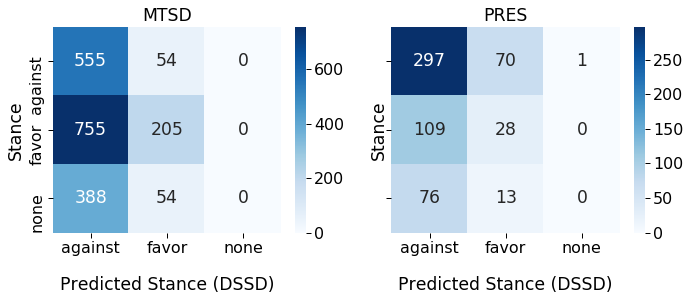

In [21]:
# fig 2
run = 2
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 1.8})
data = pd.read_csv("../outputs/all_test_%d_results.csv" %(run), sep = "\t")
data = data[data['Target'] == 'Donald Trump']
data['Dataset'] = [datasets_map[i] for i in data['Dataset']]

datas = data.groupby('Dataset')

methods = ['DSSD_%d' %(run)]
j = 0
for model in methods:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 4.5), sharey = True)
    for n, i in enumerate(['mtsd', 'pres']):
    #print(i) 
        datax = datas.get_group(i)
        datax['Stance'] = datax['Stance'].map({'AGAINST' : 'against', 'FAVOR' : 'favor', 'NONE' : 'none'})
        datax['%s'%(model)] = datax['%s'%(model)].map({'AGAINST' : 'against', 'FAVOR' : 'favor', 'NONE' : 'none'})
        sns.heatmap(confusion_matrix(datax['Stance'], datax['%s'%(model)]),
                    ax = axes[n], cmap="Blues", annot = True, fmt="d",
                       xticklabels = ['against', 'favor', 'none'],
                       yticklabels = ['against', 'favor', 'none'])
        
        axes[n].set_title(str.upper(i))
        axes[n].set_ylabel('Stance')
        axes[n].set_xlabel('Predicted Stance (DSSD)', labelpad=20)
#         for ax in fig.axes:
# #             ax.xtick_params(labelrotation=0)
#             ax.tick_params(labelrotation=40, axis = 'y')

    #sns.heatmap(pd.crosstab(datax['Stance'], datax['TD-LSTM_0']), ax = ax2, cmap="Blues", annot = True)
    #sns.heatmap(pd.crosstab(datax['TD-LSTM_0'], datax['DSSD_0']), ax = ax3, cmap="Blues", annot = True)
    plt.tight_layout()
    plt.savefig("../plots/error_analysis.pdf")
    plt.show()
    print()

/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

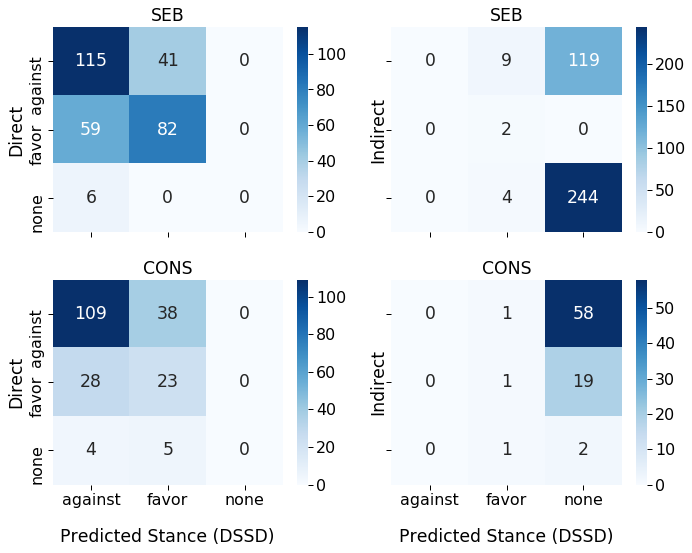

In [22]:
# fig 1
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 1.8})

j = 0
for model in methods:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize = (10, 8), sharex = True, sharey = True) 
    for n, i in enumerate(['seb', 'cons']):
        dataxes = datas.get_group(i)
        for m, j in enumerate(['Direct', 'Indirect']):
            datax = dataxes[dataxes['Direct_Stance'] == j]
            datax['Stance'] = datax['Stance'].map({'AGAINST' : 'against', 'FAVOR' : 'favor', 'NONE' : 'none'})
            datax['%s'%(model)] = datax['%s'%(model)].map({'AGAINST' : 'against', 'FAVOR' : 'favor', 'NONE' : 'none'})
            
            sns.heatmap(confusion_matrix(datax['Stance'], datax['%s'%(model)]), ax = axes[n, m],
                    cmap="Blues", annot = True, fmt="d", xticklabels = ['against', 'favor', 'none'],
                       yticklabels = ['against', 'favor', 'none'])
            axes[n, m].set_title(str.upper(i))
            axes[n, m].set_ylabel(j)
            if n == 0:
                axes[n, m].set_xlabel('')
            else:
                axes[n, m].set_xlabel('Predicted Stance (DSSD)', labelpad = 20)
#             for ax in fig.axes:
#                 ax.tick_params(labelrotation=0)
    plt.tight_layout()
    plt.savefig("../plots/error_analysis_indirect_direct.pdf")
    plt.show()
    print()

/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/bigdata/sexism/sexist_code_icwsm20/icwsm20/lib/python3.5/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

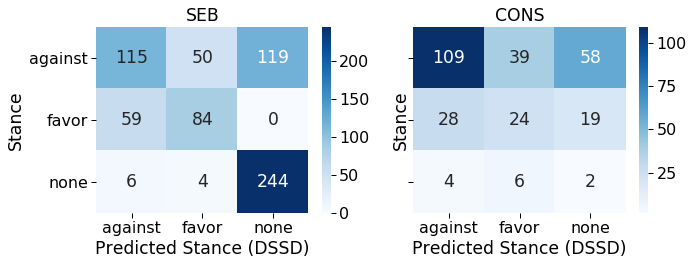

In [23]:
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 1.8})
datas = data[data['Target'] == 'Donald Trump']
datas = datas.groupby('Dataset')
methods = ['DSSD_%d' %run]
j = 0
for model in methods:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 4), sharey = True)
    for n, i in enumerate(['seb', 'cons']):
    #print(i) 
        datax = datas.get_group(i)
        datax['Stance'] = datax['Stance'].map({'AGAINST' : 'against', 'FAVOR' : 'favor', 'NONE' : 'none'})
        datax['%s'%(model)] = datax['%s'%(model)].map({'AGAINST' : 'against', 'FAVOR' : 'favor', 'NONE' : 'none'})
        sns.heatmap(confusion_matrix(datax['Stance'], datax['%s'%(model)]),
                    ax = axes[n], cmap="Blues", annot = True, fmt="d",
                       xticklabels = ['against', 'favor', 'none'],
                       yticklabels = ['against', 'favor', 'none'])
        
        axes[n].set_title(str.upper(i))
        axes[n].set_ylabel('Stance')
        axes[n].set_xlabel('Predicted Stance (DSSD)')
        for ax in fig.axes:
            ax.tick_params(labelrotation=0)

    #sns.heatmap(pd.crosstab(datax['Stance'], datax['TD-LSTM_0']), ax = ax2, cmap="Blues", annot = True)
    #sns.heatmap(pd.crosstab(datax['TD-LSTM_0'], datax['DSSD_0']), ax = ax3, cmap="Blues", annot = True)
    plt.tight_layout()
    plt.savefig("../plots/cons_seb_error_analysis.pdf")
    plt.show()
    print()

In [24]:
# examples of tweets where indirect stance is not correctly detected
cons = data[data['Dataset'] =='seb']
cons = cons[cons['Target'] == "Donald Trump"]
cons = cons[cons['DSSD_%d' %run] == 'NONE']
# cons[['Tweet', 'Stance']].values[:10] # need tweets to run this